In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/4D.csv
/kaggle/input/2E.csv
/kaggle/input/0E.csv
/kaggle/input/2D.csv
/kaggle/input/0D.csv
/kaggle/input/1D.csv
/kaggle/input/4E.csv
/kaggle/input/3D.csv
/kaggle/input/1E.csv
/kaggle/input/3E.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
import shap
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pickle


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/4D.csv
/kaggle/input/2E.csv
/kaggle/input/0E.csv
/kaggle/input/2D.csv
/kaggle/input/0D.csv
/kaggle/input/1D.csv
/kaggle/input/4E.csv
/kaggle/input/3D.csv
/kaggle/input/1E.csv
/kaggle/input/3E.csv


In [4]:
def split_and_select(dataset, num_categories=5, test_ratio=0.01):
   
    # Calculate the size of each category
    category_size = len(dataset) // num_categories

    # Initialize an empty list to store selected subsets
    selected_data = []

    # Split dataset into categories and select 10% from each category
    for i in range(num_categories):
        # Calculate start and end indices for the current category
        start_idx = i * category_size
        end_idx = (i + 1) * category_size

        # Select 10% of data from the current category
        test_start = int(start_idx + (1 - test_ratio) * category_size)
        test_end = int(start_idx + category_size)
        selected_data.append(dataset[test_start:test_end])

    # Concatenate selected subsets from each category
    selected_subset = pd.concat(selected_data)

    return selected_subset

In [7]:
def process_dataset(target_name, target_value):
    
    df0 = pd.read_csv("/kaggle/input/0D.csv").drop_duplicates()
    df1 = pd.read_csv("/kaggle/input/1D.csv").drop_duplicates()
    df2 = pd.read_csv("/kaggle/input/2D.csv").drop_duplicates()
    df3 = pd.read_csv("/kaggle/input/3D.csv").drop_duplicates()
    df4 = pd.read_csv("/kaggle/input/4D.csv").drop_duplicates()

    # Add target column
    df0["target"] = 0
    df1[target_name] = target_value
    df2[target_name] = target_value
    df3[target_name] = target_value
    df4[target_name] = target_value
    
    df0 = split_and_select(df0)
    df1 = split_and_select(df1)
    df2 = split_and_select(df2)
    df3 = split_and_select(df3)
    df4 = split_and_select(df4)
    
    # Concatenate datasets
    concatenated_df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)
    
    return concatenated_df

In [26]:
df = process_dataset('target', 1)
len(df)

1319960

In [9]:

df.head()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,target
0,5.15,1268.841,0.000528,-0.001463,0.002800,0
1,5.15,1268.841,0.001529,-0.000311,0.001525,0
2,5.15,1268.841,-0.001622,0.001525,0.001717,0
3,5.15,1268.841,-0.001087,0.000907,0.000170,0
4,5.15,1268.841,-0.001024,0.000045,0.001746,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("target", axis=1),df["target"], test_size =0.1, random_state=42)

In [13]:
X_train.shape

(1187964, 5)

In [14]:
X_train.head()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
787279,2.0,626.13001,0.000261,0.000263,0.003047
575449,5.2,1327.50710,0.002149,0.004150,0.002939
223637,10.0,2376.16720,-0.048518,-0.029950,0.007418
1098359,5.2,1273.26370,-0.000966,-0.001700,0.001366
21851,5.2,1318.77560,-0.001048,-0.000204,0.003642


In [15]:
X_train_fft = np.abs(np.fft.rfft(X_train, axis=1))
X_test_fft = np.abs(np.fft.rfft(X_test, axis=1))

In [18]:

# Initialize XGBoost classifier
xgb_model = XGBClassifier(n_estimators=50)

# Train the model
xgb_model.fit(X_train_fft, y_train)

# Generate predictions
xgb_predictions = xgb_model.predict(X_test_fft)

# Print classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     26220
           1       0.99      1.00      0.99    105776

    accuracy                           0.98    131996
   macro avg       0.98      0.97      0.98    131996
weighted avg       0.98      0.98      0.98    131996



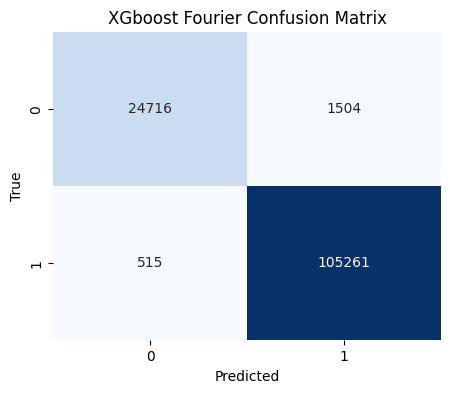

In [19]:
# Generate confusion matrix
cm = confusion_matrix(y_test, xgb_predictions)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('XGboost Fourier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train_fft, y_train)

# Generate predictions
predictions = model.predict(X_test_fft)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     26220
           1       1.00      1.00      1.00    105776

    accuracy                           1.00    131996
   macro avg       1.00      1.00      1.00    131996
weighted avg       1.00      1.00      1.00    131996



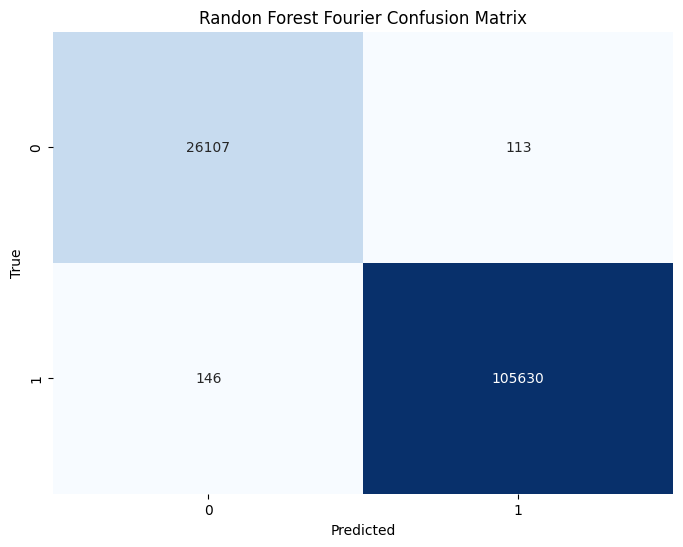

In [21]:
# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)
 
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Randon Forest Fourier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
base_classifiers = [
    ('decision_tree', DecisionTreeClassifier()),
    ('random_forest', RandomForestClassifier(n_estimators=50)),  # Random Forest instead of SVM
]

# Initialize meta classifier
meta_classifier = LogisticRegression()

# Initialize Stacking classifier
stacking_model = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# Train the model
stacking_model.fit(X_train_fft, y_train)

# Generate predictions
stacking_predictions = stacking_model.predict(X_test_fft)

# Print classification report
print("Stacking Classification Report:")
print(classification_report(y_test, stacking_predictions))

Stacking Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26220
           1       1.00      1.00      1.00    105776

    accuracy                           1.00    131996
   macro avg       1.00      1.00      1.00    131996
weighted avg       1.00      1.00      1.00    131996



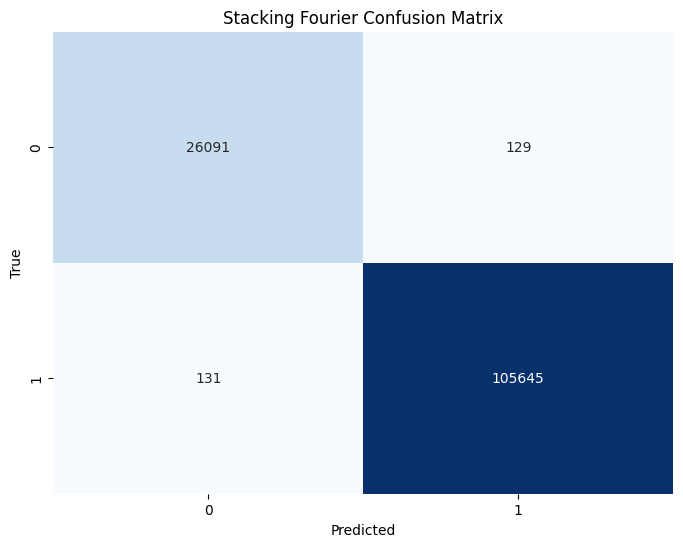

In [23]:
# Generate confusion matrix
cm = confusion_matrix(y_test, stacking_predictions)
 
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Stacking Fourier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
# Initialize individual classifiers
classifier1 = DecisionTreeClassifier()
classifier2 = RandomForestClassifier(n_estimators=100)  # Random Forest instead of SVM
classifier3 = LogisticRegression()

# Initialize Voting classifier
voting_model = VotingClassifier(estimators=[('dt', classifier1), ('rf', classifier2), ('lr', classifier3)], voting='hard')

# Train the model
voting_model.fit(X_train_fft, y_train)

# Generate predictions
voting_predictions = voting_model.predict(X_test_fft)

# Print classification report
print("Voting Classification Report:")
print(classification_report(y_test, voting_predictions))

Voting Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     26220
           1       1.00      1.00      1.00    105776

    accuracy                           1.00    131996
   macro avg       1.00      1.00      1.00    131996
weighted avg       1.00      1.00      1.00    131996



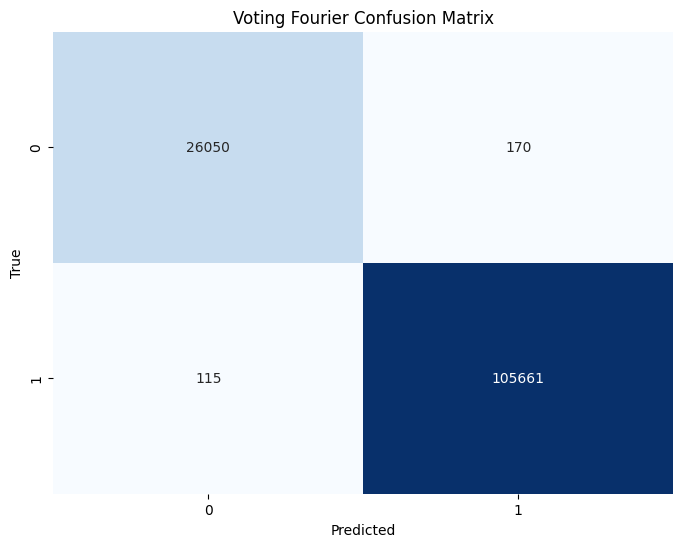

In [25]:
# Generate confusion matrix
cm = confusion_matrix(y_test, voting_predictions)
 
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Voting Fourier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
print(34)

34
